# Find a localised dark matter halo
### Fit pixelated lens potential perturbations on top of a smooth SIE model, assuming an elliptical Sérsic source.
The potential perturbation here is a single SIE localised substructure on the Einstein ring.

__last update__: 16/09/21

In [1]:
%config InlineBackend.figure_format = 'retina'

# Basic imports
from time import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import corner
%matplotlib inline
plt.rc('image', interpolation='none')

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import model_util

# Universal font size
FS = 18

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=FS, flux_vmin=3e-2, flux_vmax=7e-1, res_vmax=4)

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_grid = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_grid)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### PSF
Ignore the PSF for now.

In [3]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [4]:
# Noise
exp_time = None
sigma_bkd = 0.05
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens models (large-scale SIE + an SIE perturber)

In [6]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'SIE']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'theta_E': 0.25, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'PIXELATED']
kwargs_pixelated_lens = {'pixel_scale_factor': 4, 'conserve_extent': True}
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list,
                                   kwargs_pixelated=kwargs_pixelated_lens)

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### Image model

In [7]:
kwargs_numerics = {'supersampling_factor': 1}
pixel_grid_copy = deepcopy(pixel_grid)

# True image model
true_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=true_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Hybrid image model for fitting
hybrid_lens_image = LensImage(pixel_grid_copy, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

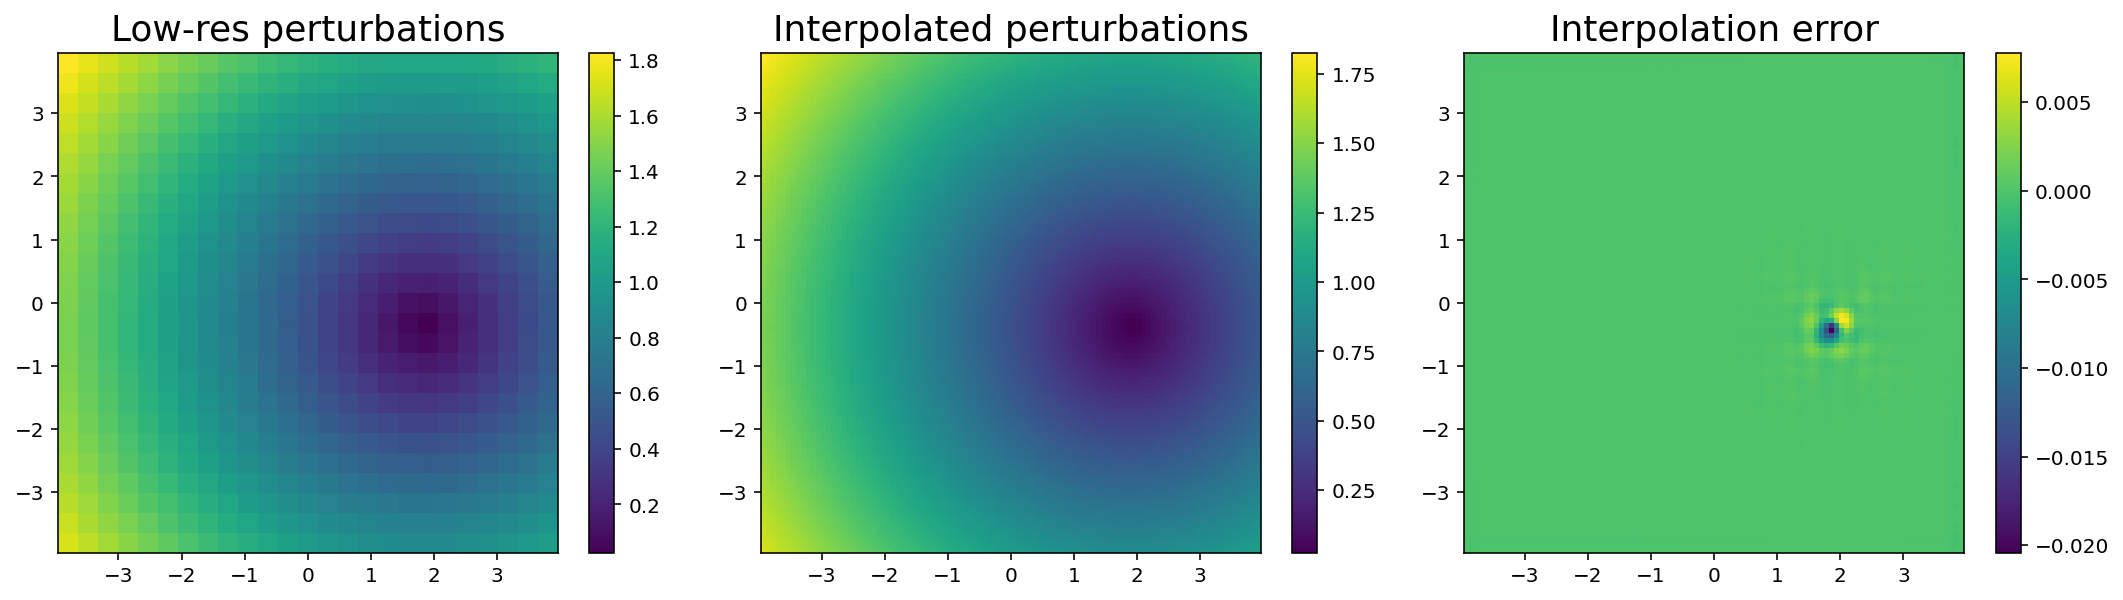

In [8]:
# Extract coordinate grids for pixelated potential
x_grid_lowres, y_grid_lowres = hybrid_lens_image.Grid.model_pixel_coordinates('lens')

# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],
                           {'pixels': psi_grid_true_lowres}]  # Transpose so that image_model works properly

# Test interpolating the low-res hybrid model to the original grid
psi_grid_interp = hybrid_lens_mass_model.potential(x_grid, y_grid, kwargs_hybrid_lens_mass, k=1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

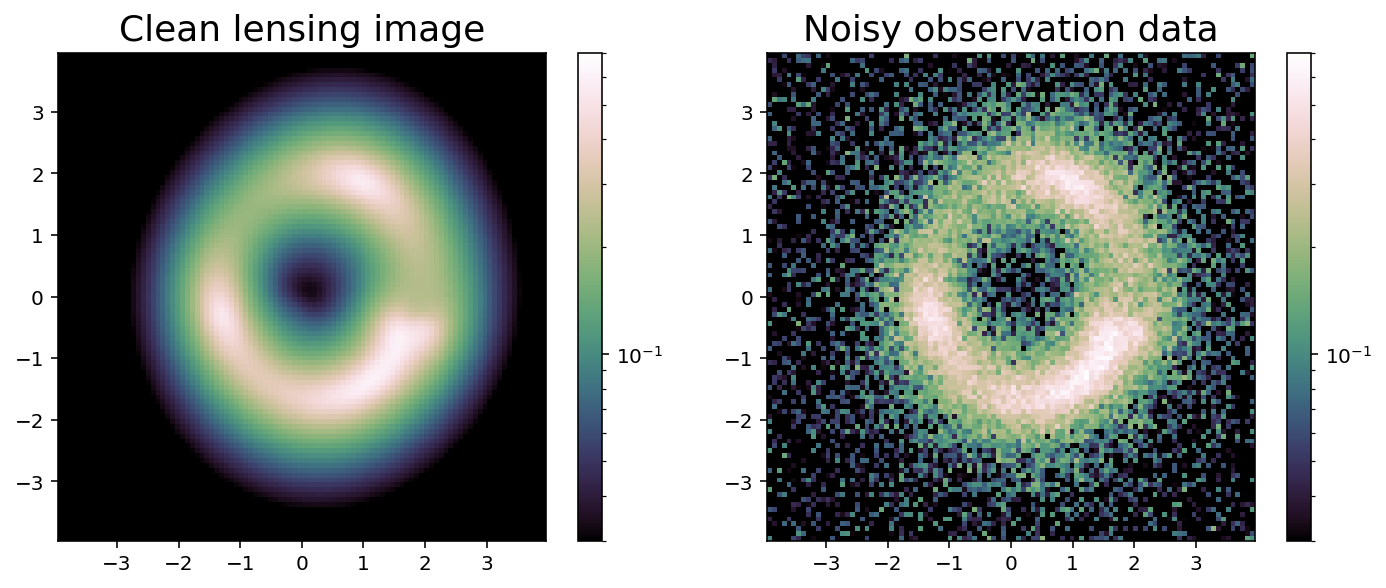

In [9]:
# Generate a lensed image based on source and lens models
image = true_lens_image.model(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

# Observed noisy data
data = true_lens_image.simulation(kwargs_lens=kwargs_true_lens_mass,
                             kwargs_source=kwargs_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

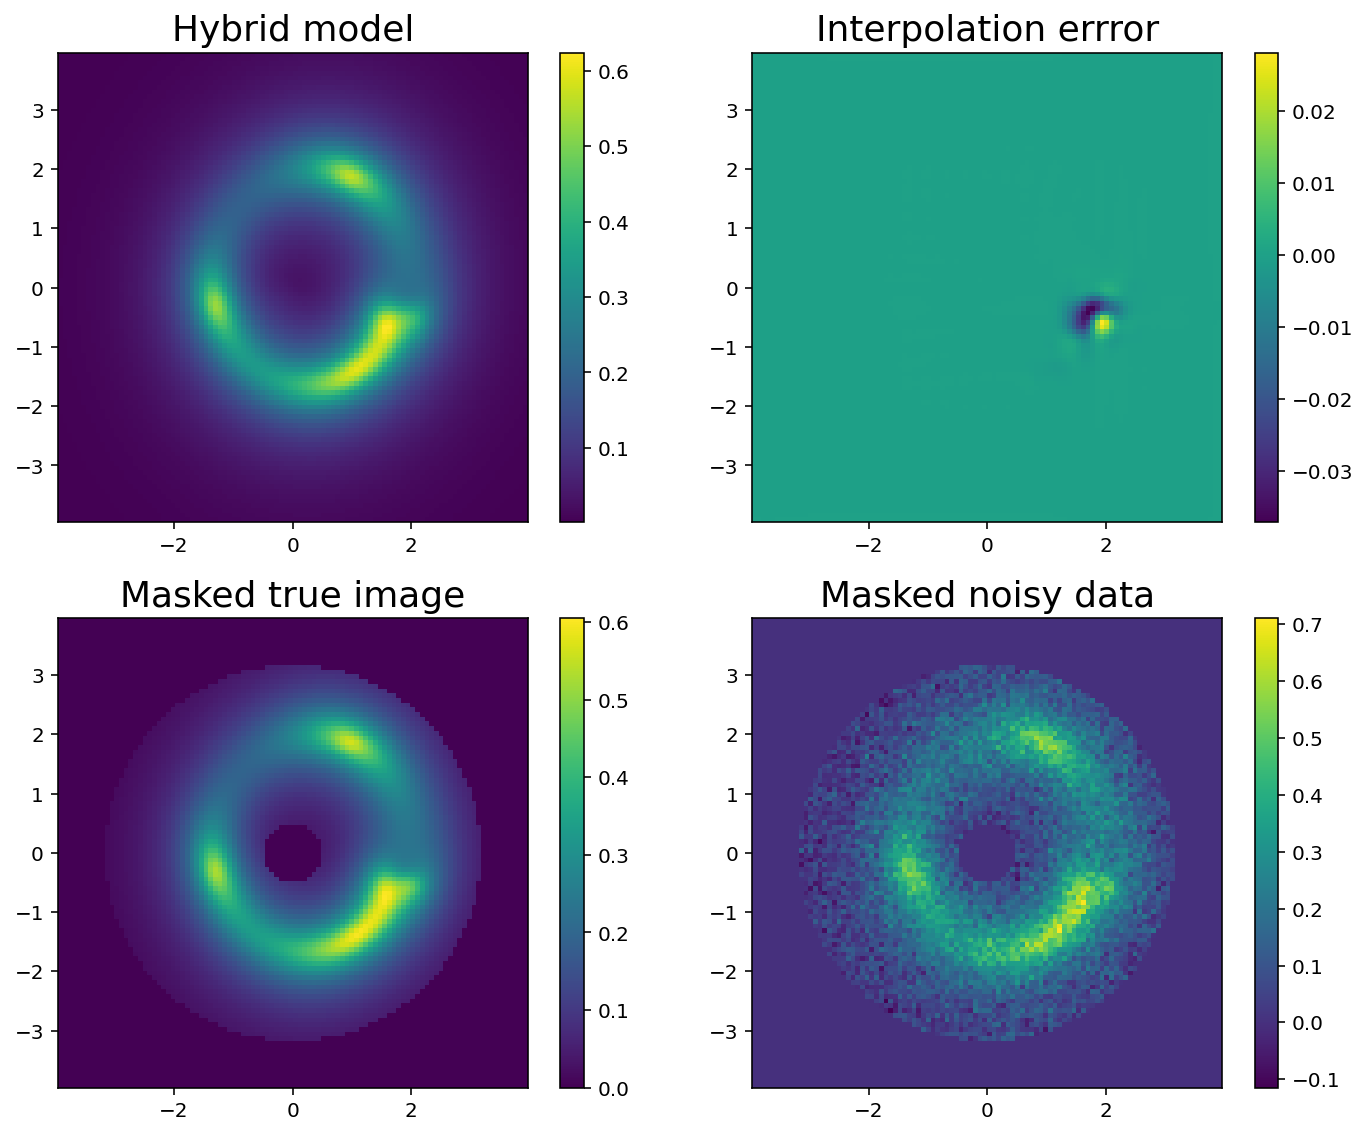

In [10]:
# Test the hybrid model with the true low-res perturbation grid
hybrid_image = hybrid_lens_image.model(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Fit the lens potential perturbation as a pixelated grid

### Parameters

Here we select which parameters to optimise, which one are fixed, lower/upper bounds (treated as "uniform" prior).

In [12]:
npix_lowres = npix // kwargs_pixelated_lens['pixel_scale_factor']
masked_lower = -10.*np.ones(npix_lowres**2)*mask_lowres.flatten()
masked_upper = +10.*np.ones(npix_lowres**2)*mask_lowres.flatten()

kwargs_model = {
    'lens_model_list': hybrid_lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {'pixels': 1e-8}],
    'kwargs_source': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {'pixels': ['uniform', masked_lower, masked_upper]}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [kwargs_hybrid_lens_mass[0], {}],
    'kwargs_source': kwargs_source_light,
}
parameters = Parameters(hybrid_lens_image, kwargs_init, 
                        kwargs_fixed, kwargs_prior=kwargs_prior)

kwargs_true = {
    'kwargs_lens': kwargs_hybrid_lens_mass, 
    'kwargs_source': kwargs_source_light,
}
p_init = parameters.kwargs2args(kwargs_init)
p_true = parameters.kwargs2args(kwargs_true)
print("truths:", len(p_true), parameters.names[0])

print(parameters.prior_types[0])
#print(parameters.bounds)

truths: 625 d_0
uniform


#### Initial $\delta\psi$ map

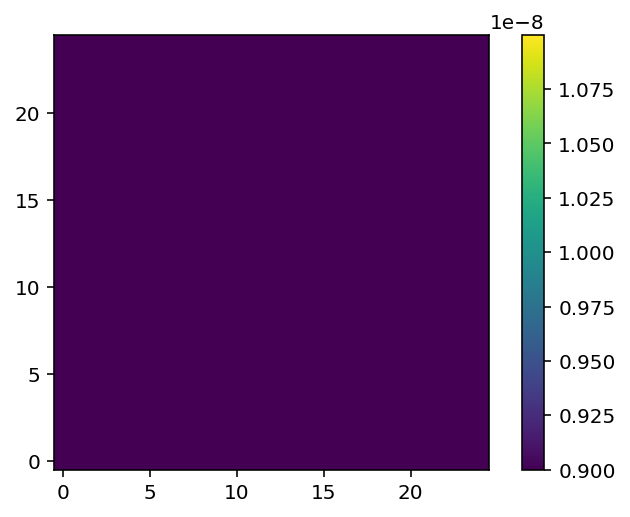

In [13]:
plt.imshow(p_init.reshape(npix_lowres, npix_lowres), origin='lower')
plt.colorbar()
plt.show()

#### Bounds for $\delta\psi$

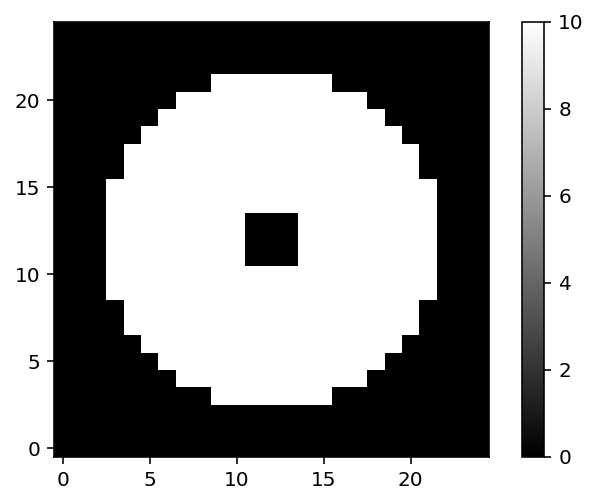

In [14]:
plt.imshow(parameters.bounds[1].reshape(npix_lowres, npix_lowres), origin='lower', cmap='gray')
plt.colorbar()
plt.show()

# Fit the perturbed pixelated potential

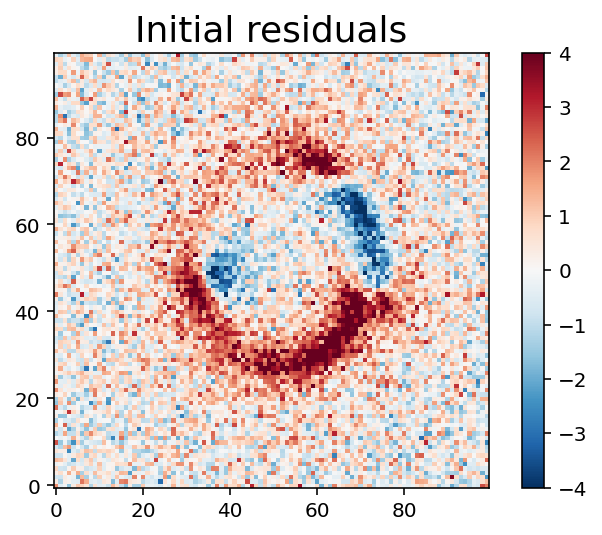

In [17]:
hybrid_image_init = hybrid_lens_image.model(**parameters.args2kwargs(p_init))

plt.title("Initial residuals", fontsize=FS)
plt.imshow((data - hybrid_image_init) / np.sqrt(true_lens_image.Noise.C_D), 
           origin='lower', cmap=plotter.cmap_res, vmin=-4, vmax=4)
plt.colorbar()
plt.show()

### Starlet regularization

#### Load pre-estimated potential noise map

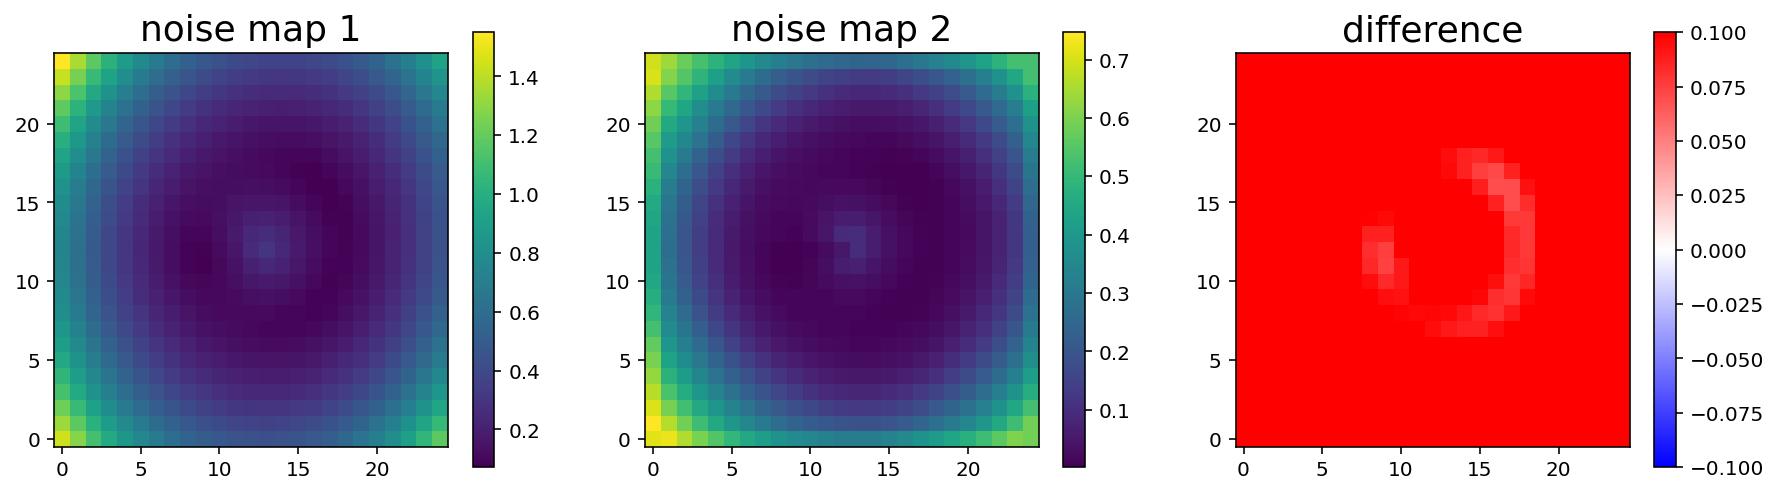

mean level: 0.17960860000000017
mean level within mask: 0.04246060739436622


In [18]:
#dpsi_noise_map1 = np.zeros((npix_lowres, npix_lowres)) # np.load(f'data/dpsi_1sigma_bkg{sigma_bkd}_{npix_lowres}px_pixmass.npy')
dpsi_noise_map2 = np.load(f'data/dpsi_1sigma_bkg{sigma_bkd}_{npix_lowres}px_fullmass_fullamp.npy')

dpsi_noise_map1 = model_util.pixel_pot_noise_map(hybrid_lens_image, 
                                                 parameters.initial_values(as_kwargs=True),
                                                 cut=1e-3)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("noise map 1", fontsize=FS)
im = ax.imshow(dpsi_noise_map1, origin='lower')
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("noise map 2", fontsize=FS)
im = ax.imshow(dpsi_noise_map2, origin='lower')
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("difference", fontsize=FS)
im = ax.imshow(dpsi_noise_map1 - dpsi_noise_map2, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
plt.show()

print("mean level:", np.mean(dpsi_noise_map2))
print("mean level within mask:", np.mean(dpsi_noise_map2[mask_lowres == 1.]))

#### Create the loss function, including $\ell_1$-norm + starlet regularization

In [19]:
# Choose noise map for potential grid regularization
#potential_noise_map = np.mean(dpsi_noise_map2[mask_lowres == 1.])
potential_noise_map = dpsi_noise_map1

# Create loss
loss = Loss(data, hybrid_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_potential', 
                                  'l1_battle_potential'], 
            regularization_strengths=[(5, 3), 10],
            potential_noise_map=potential_noise_map,
            prior_terms=None)

print("Loss at initial values:", loss(p_init))
print("Loss at true values:", loss(p_true))

Loss at initial values: 2.0604744
Loss at true values: 3.4835892


#### Launch optimization

In [20]:
optimizer = Optimizer(loss, parameters)

best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True, maxiter=None)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit))
#print(extra_fields['result_class'])

Runtime: 37.689282178878784
Loss at best-fit: 1.4277357


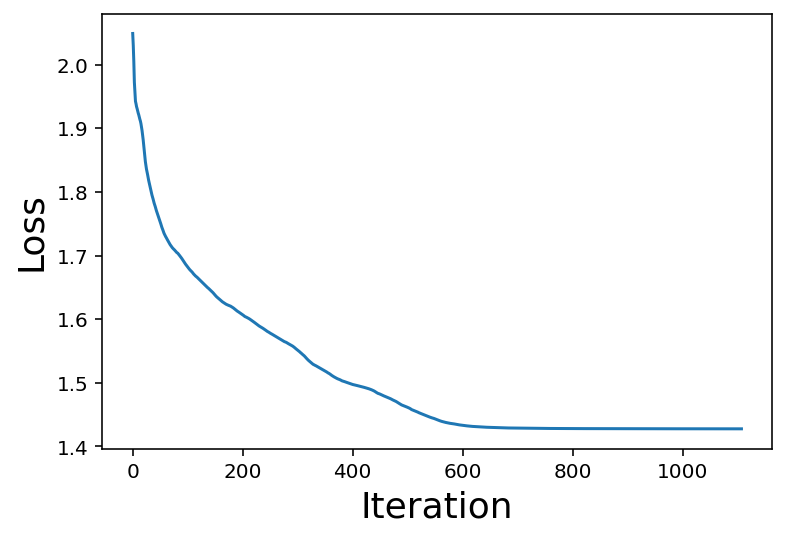

In [22]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
plt.show()

delta_psi shift by min: -0.33878285


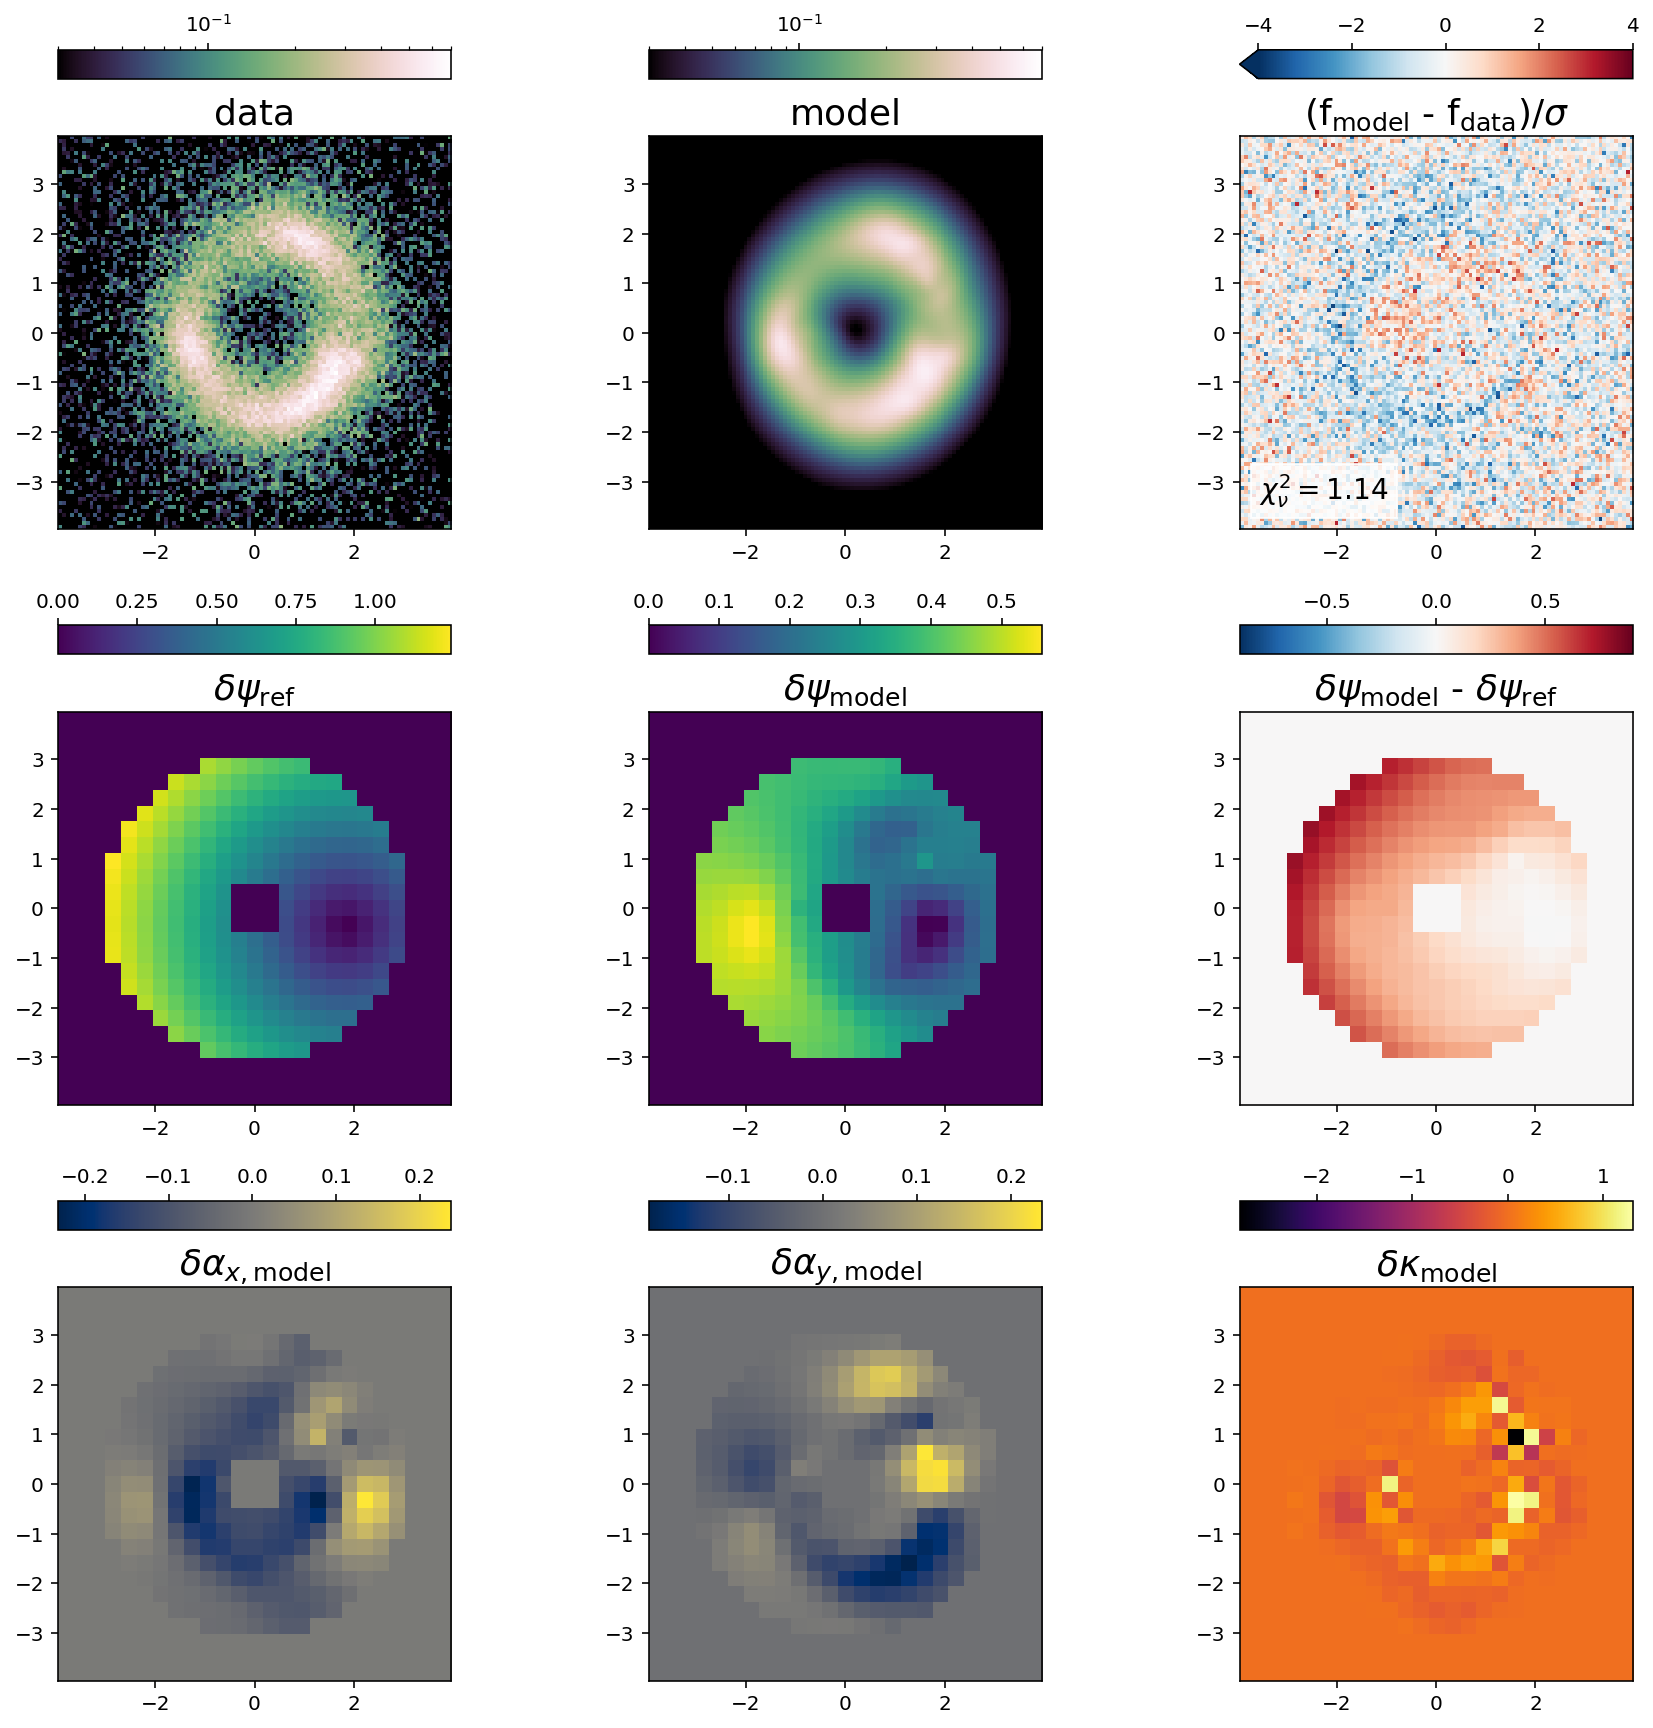

In [25]:
plotter.set_ref_pixelated_potential(psi_grid_true_lowres)
plotter.set_data(data)

kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
fig = plotter.model_summary(hybrid_lens_image, kwargs_final,
                      show_source=False, 
                      show_lens_potential=True, 
                      show_lens_others=False,
                      potential_mask=mask_lowres,
                      shift_pixelated_potential='min')

#### Look at the Fisher matrix

In [ ]:
fisher_matrix = None

if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
    
    imin, imax = 120, 140
    
    best_fit_red = best_fit[imin:imax]
    fisher_matrix_red = fisher_matrix[imin:imax, imin:imax]
    p_true_red = p_true[imin:imax]
    symbols_red = parameters.symbols[imin:imax]
    
    sqrt_fisher_matrix_red_signed = np.sqrt(np.abs(fisher_matrix_red)) * np.sign(fisher_matrix_red)
    
    plt.figure(figsize=(10, 8))
    plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
    plt.imshow(sqrt_fisher_matrix_red_signed, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix_red_signed).max(), vmax=np.abs(sqrt_fisher_matrix_red_signed).max())
    plt.colorbar(label="parameter standard deviation")
    plt.gca().set_xticks(np.arange(0, imax-imin))
    plt.gca().set_xticklabels(np.arange(imin, imax))
    plt.gca().set_yticks(np.arange(0, imax-imin))
    plt.gca().set_yticklabels(np.arange(imin, imax))
    plt.grid('on', color='black', alpha=0.2)
    plt.show()

In [ ]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

if fisher_matrix is not None:
    samples_fisher = draw_from_gaussian(best_fit_red, fisher_matrix_red, ndraws=5000)

    fig = plt.figure(figsize=(15, 15))
    fig = corner.corner(samples_fisher, truths=p_true_red, show_titles=True, labels=symbols_red,
                        fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
    plt.show()

In [ ]:
if fisher_matrix is not None:
    cov_diag = np.abs(np.diag(fisher_matrix))
    variance_map = cov_diag.reshape((npix_lowres, npix_lowres))
    
    plt.title("log(variance) map", fontsize=FS)
    plt.imshow(np.log10(variance_map), origin='lower')
    plt.colorbar()
    plt.show()